# Problem 1

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import urllib.request
import scipy.optimize
import random
from math import exp
from math import log
import time
from random import shuffle

def parseData(fname):
    for l in urllib.request.urlopen(fname):
        yield eval(l)

print("Reading data...")

data = list(parseData("file:beer_50000.json"))
shuffle(data)

print("done")

def feature(datum):
    feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
    return feat

X = np.array([feature(d) for d in data])
Y = np.array([d['beer/ABV'] >= 6.5 for d in data])

Reading data...
done


In [108]:
def sigmoid(x):
    return 1.0 / (1 + exp(-x))

##################################################
# Logistic regression by gradient ascent         #
##################################################

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
    loglikelihood = 0
    # Array of inner products for X_i, theta
    logits = np.dot(X, theta.T)
    for i in range(len(X)):
        if y[i]:
            loglikelihood -= log(1 + exp(-logits[i]))
        else:
            loglikelihood -= log(1 + exp(-logits[i]))
            loglikelihood -= logits[i]
    for k in range(len(theta)):
        loglikelihood -= lam * theta[k]*theta[k]
    #print loglikelihood
    return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
    dl = [0]*len(theta)
    # Inner product of X_i, theta
    logits = np.dot(X, theta.T)
    for i in range(len(X)):
        for k in range(len(theta)):
            if y[i]:
                dl[k] += X[i][k] * (1 - sigmoid(logits[i]))
            else:
                dl[k] += X[i][k] * (1 - sigmoid(logits[i]))
                dl[k] -= X[i][k]
    for k in range(len(theta)):
        dl[k] -= lam*2*theta[k]
    return np.array([-x for x in dl])

def train(lam, X, Y, f, fprime):
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X, Y, lam))
    return theta

def predict(X, theta):
    pred = np.dot(X, theta.T)
    assert pred.shape == (len(X),), "Expected shape: {}, but was: {}".format((len(X),), pred.shape)
    return pred > 0

def accuracy(theta, Y, X):
    predictions = predict(X, theta)
    correct = predictions == Y
    acc = sum(correct) * 1.0 / float(len(correct))
    return acc

In [109]:
n = len(X)
X_train, X_test, X_val = (X[0:n//3+1], X[n//3+1:2*n//3+1], X[2*n//3+1::])
Y_train, Y_test, Y_val = (Y[0:n//3+1], Y[n//3+1:2*n//3+1], Y[2*n//3+1::])

lam = 1.0
theta = train(lam, X_train, Y_train, f, fprime)
acc_train = accuracy(theta, Y_train, X_train)
acc_test = accuracy(theta, Y_test, X_test)
acc_val = accuracy(theta, Y_val, X_val)

print("Training accuracy: {0:.5f}".format(acc_train))
print("Testing accuracy: {0:.5f}".format(acc_test))
print("Validation accuracy: {0:.5f}".format(acc_val))

Training accuracy: 0.71915
Testing accuracy: 0.72053
Validation accuracy: 0.71853


# Problem 2

In [110]:
def true_positive(Y, predictions):
    TP = np.sum(np.logical_and(predictions == 1, Y == 1))
    return TP

def true_negative(Y, predictions):
    TN = np.sum(np.logical_and(predictions == 0, Y == 0))
    return TN

def false_positive(Y, predictions):
    FP = np.sum(np.logical_and(predictions == 1, Y == 0))
    return FP

def false_negative(Y, predictions):
    FN = np.sum(np.logical_and(predictions == 0, Y == 1))
    return FN

def balanced_error_rate(Y, predictions): 
    TP = true_positive(Y, predictions)
    FP = false_positive(Y, predictions)
    FN = false_negative(Y, predictions)
    TN = true_negative(Y, predictions)
    TPR = TP / float((TP + FN))
    TNR = TN / float((TN + FP))
    return 1. - 0.5 * (TPR + TNR)

In [111]:
predictions = predict(X_test, theta)
print("True Positive:", true_positive(Y_test, predictions))
print("True Negative:", true_negative(Y_test, predictions))
print("False Positive:", false_positive(Y_test, predictions))
print("False Negative:", false_negative(Y_test, predictions))
print("Balanced Error rate:", balanced_error_rate(Y_test, predictions))

True Positive: 9059
True Negative: 2950
False Positive: 3288
False Negative: 1370
Balanced Error rate: 0.32922824057303646


# Problem 3

The classifier is less effective than it could be as the class imbalance, there are far more False positives campared as False Negatives.
The False positives stress more influence on the balanced error rate, so we need to assign less importance on False Positives, assign 10 times importance on False Negatives. We need to make coefficient of False Positive 10 times less than False Negative, which is |y_i == 1| is 10 times compared with |y_i == 0|. 









In [132]:
TP = true_positive(Y_test, predictions)
TN = true_negative(Y_test, predictions)
FP = false_positive(Y_test, predictions)
FN = false_negative(Y_test, predictions)
def get_weight_const(y):
    n = float(len(y))
    y1 = float(np.count_nonzero(y))
    y0 = n - y1
    c1 = n / ( y1 * 10 * 2.)
    c0 = n/ ( y0 * 2.)
    return c0, c1

# Negative log likelihood
def f(theta, X, y, lam):
    c0, c1 = get_weight_const(y)
    loglikelihood = 0
    # Array of inner products for X_i, theta
    logits = np.dot(X, theta.T)
    for i in range(len(X)):
        if y[i]:
            loglikelihood -= log(1 + exp(-logits[i])) * c1
        else:
            loglikelihood -= log(1 + exp(-logits[i])) * c0
            loglikelihood -= logits[i] * c0
    for k in range(len(theta)):
        loglikelihood -= lam * theta[k]*theta[k]
    #print loglikelihood
    return -loglikelihood

In [133]:
# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
    c0, c1 = get_weight_const(y)
    dl = [0]*len(theta)
    # Inner product of X_i, theta
    logits = np.dot(X, theta.T)
    for i in range(len(X)):
        for k in range(len(theta)):
            if y[i]:
                dl[k] += X[i][k] * (1 - sigmoid(logits[i])) * c1
            else:
                dl[k] += X[i][k] * (1 - sigmoid(logits[i])) * c0
                dl[k] -= X[i][k] * c0
    for k in range(len(theta)):
        dl[k] -= lam*2*theta[k]
    return np.array([-x for x in dl])

In [134]:
def print_metrics(X, Y, theta):
    predictions  = predict(X, theta)
    print("True Positive:", true_positive(Y, predictions))
    print("True Negative:", true_negative(Y, predictions))
    print("False Positive:", false_positive(Y, predictions))
    print("False Negative:", false_negative(Y, predictions))
    print("Balanced Error rate:", balanced_error_rate(Y, predictions))
    print("Accuracy:", accuracy(theta, Y, X))

In [135]:
n = len(X)
X_train, X_test, X_val = (X[0:n//3+1], X[n//3+1:2*n//3+1], X[2*n//3+1::])
Y_train, Y_test, Y_val = (Y[0:n//3+1], Y[n//3+1:2*n//3+1], Y[2*n//3+1::])

lam = 1.0
theta = train(lam, X_train, Y_train, f, fprime)
print("-----\nTraining set:")
print_metrics(X_train, Y_train, theta)
print("-----\nTesting set:")
print_metrics(X_test, Y_test, theta)
print("-----\nValidation set:")
print_metrics(X_val, Y_val, theta)
















-----
Training set:
True Positive: 91
True Negative: 6284
False Positive: 6
False Negative: 10286
Balanced Error rate: 0.49609225060987727
Accuracy: 0.38249235015299693
-----
Testing set:
True Positive: 83
True Negative: 6234
False Positive: 4
False Negative: 10346
Balanced Error rate: 0.4963413270595277
Accuracy: 0.379012419751605
-----
Validation set:
True Positive: 73
True Negative: 6298
False Positive: 5
False Negative: 10290
Balanced Error rate: 0.49687449042560083
Accuracy: 0.3822752910116405


# Problem 4

In [24]:
def get_BER(lam, f, fprime, X, Y):
    n = len(X)
    X_train, X_test, X_val = (X[0:n//3+1], X[n//3+1:2*n//3+1], X[2*n//3+1::])
    Y_train, Y_test, Y_val = (Y[0:n//3+1], Y[n//3+1:2*n//3+1], Y[2*n//3+1::])

    # Find theta on training data
    theta = train(lam, X_train, Y_train, f, fprime)
    # Tune the lambda with validation set
    predictions = predict(X_val, theta)
    # Tune the lambda with validation set
    BER = balanced_error_rate(Y_val, predictions)
    print("lam={} \t ber={}".format(lam, BER))
    return BER

lams = [0.00, 0.01, 0.10, 1.0, 7.5, 8.0, 8.5, 10.0, 50.0, 100.0]
BERs = []
for lam in lams:
    b = get_BER(lam, f, fprime, X, Y)
    BERs.append(b)

lam=0.0 	 ber=0.4613944158070208
lam=0.01 	 ber=0.4613944158070208
lam=0.1 	 ber=0.4613944158070208
lam=1.0 	 ber=0.4613944158070208
lam=7.5 	 ber=0.4613944158070208
lam=8.0 	 ber=0.4613944158070208
lam=8.5 	 ber=0.4613944158070208
lam=10.0 	 ber=0.4613944158070208
lam=50.0 	 ber=0.4613944158070208
lam=100.0 	 ber=0.4613944158070208


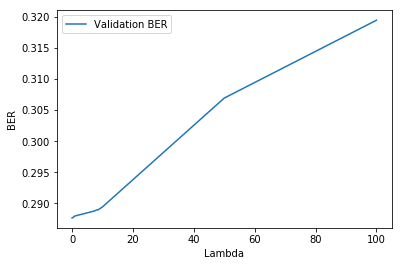

In [11]:
plt.plot(lams, BERs, label="Validation BER")
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('BER')
plt.show()

In [12]:
lam = 1
theta = train(lam, X_train, Y_train, f, fprime)
print("-----\nTraining set:")
print_metrics(X_train, Y_train, theta)
print("-----\nTesting set:")
print_metrics(X_test, Y_test, theta)
print("-----\nValidation set:")
print_metrics(X_val, Y_val, theta)

-----
Training set:
True Positive: 7725
True Negative: 4254
False Positive: 1978
False Negative: 2710
Balanced Error rate: 0.28854850892467765
Accuracy: 0.7187256254874903
-----
Testing set:
True Positive: 7651
True Negative: 4263
False Positive: 2072
False Negative: 2681
Balanced Error rate: 0.29327845902768424
Accuracy: 0.7148257034859303
-----
Validation set:
True Positive: 7715
True Negative: 4274
False Positive: 1990
False Negative: 2687
Balanced Error rate: 0.28800204327539913
Accuracy: 0.71936877475099


# Problem 5

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
G = nx.karate_club_graph()
plt.show()
plt.clf()

<Figure size 432x288 with 0 Axes>

In [6]:
edges = set()
nodes = set()
for edge in urllib.request.urlopen("file:egonet.txt"):
    x, y = edge.split()
    x, y = int(x), int(y)
    edges.add((x,y))
    edges.add((y,x))
    nodes.add(x)
    nodes.add(y)

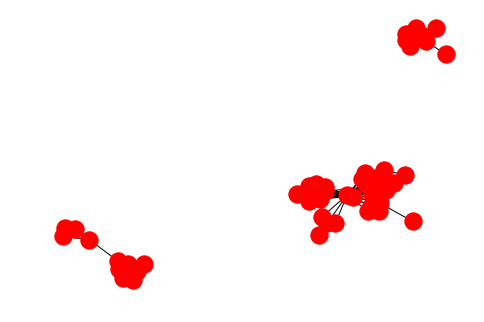

<Figure size 432x288 with 0 Axes>

In [7]:
G = nx.Graph()
for e in edges:
    G.add_edge(e[0], e[1])
nx.draw(G)
plt.show()
plt.clf()

In [8]:
connectedComponents = list(nx.connected_components(G))
print(len(connectedComponents))
print(len(connectedComponents[0]))

3
40


# Problem 6

In [211]:
nodes_connected = connectedComponents[0]
l = list(nodes_connected)
l.sort()
nodes_left = l[:len(nodes_connected)//2]
nodes_right = l[len(nodes_connected)//2:]

In [212]:
print(len(nodes_left), len(nodes_right))

20 20


In [213]:
degree_sum = 0
for node in nodes_connected:
    degree_sum += G.degree(node)
degree_sum_left = 0
for node in nodes_left:
    degree_sum_left += G.degree(node)
degree_sum_right = degree_sum - degree_sum_left
print(degree_sum, degree_sum_left, degree_sum_right)

440 242 198


In [214]:
cut_count = 0
for (x, y) in edges:
    if x in nodes_left and y in nodes_right:
        cut_count += 1
        cut_edges = cut_count//2
print(cut_edges)
norm = ((cut_count*1.0/degree_sum_left)+(cut_count*1.0/degree_sum_right))/2
print(norm)

46
0.42240587695133147


In [215]:
def cut(S, T, graph):
    count = 0
    for n in S:
        for m in T:
            if graph.has_edge(n,m):
                count = count+1
    return count

In [216]:
def norm_cut(S, T, graph):
    ST_cut = cut(S,T,graph)
    norm = ((cut_count*1.0/degree_sum_left)+(cut_count*1.0/degree_sum_right))/2
    return norm

In [217]:
norm_cut(nodes_left, nodes_right, G)

0.42240587695133147

# Problem 7

In [218]:
from networkx.algorithms import community

In [219]:
nodes_connected = connectedComponents[0]
l = list(nodes_connected)
l.sort()
nodes_left = l[:len(nodes_connected)//2]
nodes_right = l[len(nodes_connected)//2:]
norm = norm_cut(nodes_left, nodes_right, G)
norm_cut_move = 0

In [220]:
i = 0
while i < len(nodes_left):
    selected_node = nodes_left[i]
    nodes_right.append(selected_node)
    nodes_left.remove(selected_node)
    degree_sum_left -= G.degree(selected_node)
    degree_sum_right += G.degree(selected_node)
    if norm_cut(nodes_left, nodes_right, G) < norm:
        norm = norm_cut(nodes_left, nodes_right, G)
    else:
        nodes_right.remove(selected_node)
        nodes_left.append(selected_node)
        degree_sum_left += G.degree(selected_node)
        degree_sum_right -= G.degree(selected_node)
    i += 1
print(nodes_left,nodes_right)
print(len(nodes_right))
norm

[703, 713, 729, 747, 769, 774, 800, 804, 810, 819, 719, 753, 803, 811, 745, 805, 798, 708] [823, 825, 828, 830, 840, 856, 861, 863, 864, 869, 876, 878, 880, 882, 884, 886, 888, 889, 890, 893, 697, 772]
22


0.4182163815191338

In [221]:
i = 0
while i < len(nodes_right):
    selected_node = nodes_right[i]
    nodes_left.append(selected_node)
    nodes_right.remove(selected_node)
    degree_sum_right -= G.degree(selected_node)
    degree_sum_left += G.degree(selected_node)
    if norm_cut(nodes_left, nodes_right, G) < norm:
        norm = norm_cut(nodes_left, nodes_right, G)
    else:
        nodes_left.remove(selected_node)
        nodes_right.append(selected_node)
        degree_sum_right += G.degree(selected_node)
        degree_sum_left -= G.degree(selected_node)
    i += 1
print(nodes_left,nodes_right)
print(len(nodes_right))
print("The normalized cost is", norm)

[703, 713, 729, 747, 769, 774, 800, 804, 810, 819, 719, 753, 803, 811, 745, 805, 798, 708, 884] [825, 830, 856, 863, 869, 878, 882, 886, 889, 893, 772, 828, 861, 876, 888, 697, 840, 880, 823, 890, 864]
21
The normalized cost is 0.41819045848054714


# Problem 8

In [239]:
import community
from networkx.algorithms.community.quality import modularity
from networkx.algorithms import community
import igraph

edges_sum = 440

In [245]:
def modularity(nodes_left, nodes_right, edges):
    edges_only_in_first = 0
    edges_only_in_second = 0
    edges_in_first = 0
    edges_in_second = 0
    for (x, y) in edges:
        if x in nodes_left and y in nodes_left:
            edges_only_in_first += 1
        if x in nodes_left or y in nodes_left:
            edges_in_first += 1
        if x in nodes_right and y in nodes_right:
            edges_only_in_second += 1
        if x in nodes_right or y in nodes_right:
            edges_in_second += 1
    e11 = edges_only_in_first//2 *1.0/edges_sum
    a1 = edges_in_first//2 *2.0/edges_sum
    e22 = edges_only_in_second//2 *1.0/edges_sum
    a2 = edges_in_second//2 *2.0/edges_sum
    Q = (e11-a1**2) + (e22-a2**2)
    return("modularity score = " ,Q, edges_only_in_first, edges_only_in_second, edges_in_first, edges_in_second, edges_sum)

In [246]:
modularity(nodes_left, nodes_right, edges)

('modularity score = ', -0.4879132231404959, 198, 116, 324, 242, 440)

In [247]:
degrees = [val for (node, val) in G.degree()]

In [248]:
i = 0
modularity_score = modularity(nodes_left, nodes_right, edges)
while i < len(nodes_left):
    selected_node = nodes_left[i]
    nodes_right.append(selected_node)
    nodes_left.remove(selected_node)
    if modularity_score < modularity(nodes_left, nodes_right, edges):
        modularity_score = modularity(nodes_left, nodes_right, edges)
    else:
        nodes_right.remove(selected_node)
        nodes_left.append(selected_node)
        mpdularity_score = modularity(nodes_left, nodes_right, edges)
    i += 1
print(nodes_left,nodes_right)
print(len(nodes_right))
modularity_score

[805, 745, 769, 713, 823, 810, 708, 703, 803, 774, 880, 811, 772, 800, 819, 830, 798, 840, 719, 869, 747] [863, 886, 828, 697, 890, 884, 889, 825, 882, 753, 893, 729, 888, 864, 876, 861, 856, 878, 804]
19


('modularity score = ', -0.407603305785124, 196, 136, 304, 244, 440)

In [249]:
i = 0
modularity_score = modularity(nodes_left, nodes_right, edges)
while i < len(nodes_right):
    selected_node = nodes_right[i]
    nodes_left.append(selected_node)
    nodes_right.remove(selected_node)
    if modularity_score < modularity(nodes_left, nodes_right, edges):
        modularity_score = modularity(nodes_left, nodes_right, edges)
    else:
        nodes_left.remove(selected_node)
        nodes_right.append(selected_node)
        mpdularity_score = modularity(nodes_left, nodes_right, edges)
    i += 1
print(nodes_left,nodes_right)
print(len(nodes_right))
modularity_score

[805, 745, 769, 713, 823, 810, 708, 703, 803, 774, 880, 811, 772, 800, 819, 830, 798, 840, 719, 869, 747, 828, 890] [886, 697, 884, 825, 753, 729, 864, 861, 878, 863, 882, 888, 856, 889, 876, 893, 804]
17


('modularity score = ', -0.2976652892561984, 238, 128, 312, 202, 440)

In [204]:
def _naive_greedy_modularity_communities(G):
    """Find communities in graph using the greedy modularity maximization.
    This implementation is O(n^4), much slower than alternatives, but it is
    provided as an easy-to-understand reference implementation.
    """
    # First create one community for each node
    communities = list([frozenset([u]) for u in G.nodes()])
    # Track merges
    merges = []
    # Greedily merge communities until no improvement is possible
    old_modularity = None
    new_modularity = modularity(nodes_left, nodes_right, edges)
    while old_modularity is None or new_modularity > old_modularity:
        # Save modularity for comparison
        old_modularity = new_modularity
        # Find best pair to merge
        trial_communities = list(communities)
        to_merge = None
        for i, u in enumerate(communities):
            for j, v in enumerate(communities):
                # Skip i=j and empty communities
                if j <= i or len(u) == 0 or len(v) == 0:
                    continue
                # Merge communities u and v
                trial_communities[j] = u | v
                trial_communities[i] = frozenset([])
                trial_modularity = modularity(nodes_left, nodes_right, edges)
                if trial_modularity >= new_modularity:
                    # Check if strictly better or tie
                    if trial_modularity > new_modularity:
                        # Found new best, save modularity and group indexes
                        new_modularity = trial_modularity
                        to_merge = (i, j, new_modularity - old_modularity)
                    elif (
                        to_merge and
                        min(i, j) < min(to_merge[0], to_merge[1])
                    ):
                        # Break ties by choosing pair with lowest min id
                        new_modularity = trial_modularity
                        to_merge = (i, j, new_modularity - old_modularity)
                # Un-merge
                trial_communities[i] = u
                trial_communities[j] = v
        if to_merge is not None:
            # If the best merge improves modularity, use it
            merges.append(to_merge)
            i, j, dq = to_merge
            u, v = communities[i], communities[j]
            communities[j] = u | v
            communities[i] = frozenset([])
    # Remove empty communities and sort
    communities = [c for c in communities if len(c) > 0]
    for com in sorted(communities, key=lambda x: len(x), reverse=True):
        yield com
    return communities

In [185]:
_naive_greedy_modularity_communities(G)

<generator object _naive_greedy_modularity_communities at 0x102271acf0>